To guarantee victory, Arya must not only maximize her score but also minimize Mario's opportunities to secure higher-value scores. Choosing an immediate, tempting gain might cost her a more valuable score later. Thus, she must anticipate the possible scenarios she may face. In other words, to determine whether Arya’s victory is guaranteed, we need to compare the maximum score she can achieve with Mario’s maximum score, assuming both play optimally.
Specifically, the maximum score Arya can achieve by taking a number from either the beginning or the end of the array is calculated as the maximum between the score obtained by:
Choosing the number at the beginning plus the total sum of the array minus the optimal score Mario can achieve from the remaining numbers, and
Choosing the number at the end plus the total sum of the array minus the optimal score Mario can achieve from the remaining numbers.
The optimal gain for any subarray nums[i:j] can be expressed as:

optimal_gain = max(nums[i] + sum(nums[i:j]) - optimal_score_in_remaining_numbers,nums[j] + sum(nums[i:j]) - optimal_score_in_remaining_numbers)

After defining how to compute the optimal_gain, we can simulate all possible situations during the game based on the choices of taking numbers from either the beginning or the end of the array.  The maximum value of the optimal_gain among all subarrays represents the highest score Arya can achieve by playing optimally.


<Strong>Function</Strong> max_score_1(nums, i, j):<br>
    <Strong>Input:</Strong> nums: list of numbers, i, j: initial and ending indexes of the subarray<br>
    <Strong>Output:</Strong> Maximum score Arya can achieve in the subarray<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>if</Strong> i is equal to j <Strong>then</Strong>:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> nums[i]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>end if</Strong><br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;array_sum &larr; sum of nums[i:j+1]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;take_start &larr; nums[i] + (array_sum - max_score_1(nums, i+1, j))<br>
    &nbsp;&nbsp;&nbsp;&nbsp;take_end &larr; nums[j] + (array_sum - max_score_1(nums, i, j-1))<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;result &larr; max(take_start, take_end)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> result<br><br>
    <Strong>end</Strong><br><br>

<Strong>Function</Strong> predict_victory_1(nums):<br>
    <Strong>Input:</Strong> nums: list of integers<br>
    <Strong>Output:</Strong> Boolean indicating whether Arya can guarantee a win or not<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;n &larr; length of nums<br>
    &nbsp;&nbsp;&nbsp;&nbsp;arya_score &larr; max_score_1(nums, 0, n-1)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;total_score &larr; sum of nums<br>
    &nbsp;&nbsp;&nbsp;&nbsp;mario_score &larr; total_score - arya_score<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> arya_score is greater than or equal to mario_score<br><br>
    <Strong>end</Strong><br><br>

<Strong>Algorithm</Strong> main():<br>
    <Strong>Output:</Strong> Prints whether Arya can guarantee a win or not<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;nums &larr; [sequence of numbers]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;result &larr; predict_victory_1(nums)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Print result<br>
    <Strong>end</Strong>



In [23]:
import random
def max_score_1(nums, i, j):
    #If the subarray has only one number
    if i == j:
        return nums[i]
    #Sum of the subarray nums[i:j+1]
    array_sum = sum(nums[i:j+1])
    #Arya has two choices
    take_start = nums[i] +(array_sum-max_score_1(nums,i+1,j))
    take_end = nums[j] +(array_sum-max_score_1(nums,i,j-1))
    #Maximum score between two choices
    result = max(take_start, take_end)
    return result

def predict_victory_1(nums):
    n =len(nums)
    arya_score =max_score_1(nums, 0,n-1)
    total_score =sum(nums)
    mario_score =total_score-arya_score
    return arya_score >mario_score or(arya_score == mario_score)

array = [[31, 5, 233, 7,423,234,1,321,2,1,3,3,1,31,1],
         [1, 5, 2,3,42,41,1,11,1],
         [11, 5, 233, 27,423,234,1,321,2,77,543,423,52,55,53,1,1,31],
         [1, 5, 233, 7,43,234,1,321,2,1,3,3,1,43,21312,5,312,1,10],
         [random.randint(1, 50) for _ in range(15)],
         [random.randint(1, 50) for _ in range(20)],
         [random.randint(1, 50) for _ in range(25)]]
for item in array:
    arya_result= predict_victory_1(item)
    print(arya_result)


False
False
True
False
True
True
False


The most computationally expensive operation in the `predict_victory_1` algorithm lies in the `max_score_1` function. This function is recursive and makes two calls for each invocation, corresponding to the two possible choices Arya can make: selecting the number at the beginning or the end of the array. <br>
Each recursive call reduces the problem size by 1 (i.e., from size `n` to `n-1`), and it leads to a time complexity of approximately  $O(2^n) $.<br>
Additionally, the algorithm includes some `sum` operations which, in the most computationally expensive case, have a time complexity of $O(n)$. However, these operations are less dominant compared to the recursive function `max_score_1`. All other operations within the algorithm have constant complexity and therefore do not affect the overall asymptotic complexity.<br>
In conclusion, the algorithm has an overall time complexity of $O(2^n) $, which is exponential. Such complexity makes the algorithm inefficient for large inputs.


Each time the algorithm computes the optimal gain of a subarray, all necessary calculations are performed. However, there may be a significant amount of repetitive computation. For instance, in the array [1, 3, 5, 2, 3, 1], the subarray [5, 2] may need to be computed multiple times based on how the two players choose their numbers. This characteristic significantly slows down the performance of the algorithm.
Fortunately, this inefficiency can be addressed using dynamic programming. By storing the result of each computation in a memoization dictionary, subsequent requests for the same computation can be retrieved in 
$O(1)$ time. This approach drastically accelerates the execution of the algorithm. The pseudocode for the updated algorithm is as follows:<br><br>
<Strong>Function</Strong> max_score_2(nums, i, j, memo):<br>
    <Strong>Input:</Strong> nums: list of numbers, i, j: initial and ending indexes of the subarray, memo: dictionary for memoization<br>
    <Strong>Output:</Strong> Maximum score Arya can achieve in the subarray<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>if</Strong> i is equal to j <Strong>then</Strong>:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> nums[i]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>end if</Strong><br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>if</Strong> (i, j) exists in memo <Strong>then</Strong>:<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> memo[(i, j)]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>end if</Strong><br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;array_sum &larr; sum of nums[i:j+1]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;take_start &larr; nums[i] + (array_sum - max_score_2(nums, i+1, j, memo))<br>
    &nbsp;&nbsp;&nbsp;&nbsp;take_end &larr; nums[j] + (array_sum - max_score_2(nums, i, j-1, memo))<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;result &larr; max(take_start, take_end)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;memo[(i, j)] &larr; result<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> result<br><br>
    <Strong>end</Strong><br><br>

<Strong>Function</Strong> predict_victory_2(nums):<br>
    <Strong>Input:</Strong> nums: list of integers<br>
    <Strong>Output:</Strong> Boolean indicating whether Arya can guarantee a win or not<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;n &larr; length of nums<br>
    &nbsp;&nbsp;&nbsp;&nbsp;memo &larr; {}<br>
    &nbsp;&nbsp;&nbsp;&nbsp;arya_score &larr; max_score_2(nums, 0, n-1, memo)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;total_score &larr; sum of nums<br>
    &nbsp;&nbsp;&nbsp;&nbsp;mario_score &larr; total_score - arya_score<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;<Strong>return</Strong> arya_score is greater than or equal to mario_score<br><br>
    <Strong>end</Strong><br><br>

<Strong>Algorithm</Strong> main():<br>
    <Strong>Output:</Strong> Prints whether Arya can guarantee a win or not<br><br>
    &nbsp;&nbsp;&nbsp;&nbsp;nums &larr; [sequence of numbers]<br>
    &nbsp;&nbsp;&nbsp;&nbsp;result &larr; predict_victory_2(nums)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;Print result<br>
    <Strong>end</Strong>


The updated algorithm provides a polynomial time complexity, as it avoids computing repetitive subarrays multiple times. Instead, each subarray is computed exactly once by using a memoization dictionary. The total number of unique subarrays is $\frac{n(n+1)}{2}$​, which can be generalized to $O(n^2)$, making the algorithm polynomial in time complexity.

In [24]:
import random
def max_score_2(nums, i, j, memo):
    #If the subarray has only one number
    if i == j:
        return nums[i]
    #If the subarray is already computed, return its value
    if (i, j) in memo:
        return memo[(i, j)]
    #Sum of the subarray nums[i:j+1]
    array_sum = sum(nums[i:j+1])
    #Arya has two choices
    take_start = nums[i] +(array_sum-max_score_2(nums,i+1, j,memo))
    take_end = nums[j] +(array_sum-max_score_2(nums, i,j-1,memo))
    #Maximum score between two choices
    result = max(take_start, take_end)
    #Save the result in memoization dictionary
    memo[(i, j)] = result
    return result

def predict_victory_2(nums):
    n = len(nums)
    memo = {}
    arya_score =max_score_2(nums, 0,n-1,memo)
    total_score =sum(nums)
    mario_score =total_score-arya_score
    return arya_score > mario_score or (arya_score == mario_score)

array = [[31, 5, 233, 7,423,234,1,321,2,1,3,3,1,31,1],
         [1, 5, 2,3,42,41,1,11,1],
         [11, 5, 233, 27,423,234,1,321,2,77,543,423,52,55,53,1,1,31],
         [1, 5, 233, 7,43,234,1,321,2,1,3,3,1,43,21312,5,312,1,10],
         [random.randint(1, 50) for _ in range(15)],
         [random.randint(1, 50) for _ in range(20)],
         [random.randint(1, 50) for _ in range(25)]]
for item in array:
    arya_result= predict_victory_2(item)
    print(arya_result)


False
False
True
False
True
True
False


Comparing the result values and running times

In [28]:
import time

array = [[1, 5, 233, 7],
         [1, 5, 2,3,42,41,1,11,1],
         [11, 5, 233, 27,423,234,1,321,2,77,543,423,52,55,53,1,1,31],
         [1, 5, 233, 7,43,234,1,321,2,1,3,3,1,43,21312,5,312,1,10],
         [1, 15, 2323, 7,43,234,1,521,2,1,3,3,3,43,212,5,12],
         [1,12,12,123,1,4,5432,5645,6,523,423,423,251,4,124,12,4,12,5,47,65,98,76,8,5,3235,2]]

start_time_ndp = time.time()
print("Start running the algorithm without dynamic programming")
for item in array:

    arya_result= predict_victory_1(item)
    print(arya_result)

end_time_ndp = time.time()
print("End")
execution_time_ndp = end_time_ndp -start_time_ndp

start_time_dp = time.time()
print("Start running the algorithm with dynamic programming")
for item in array:

    arya_result= predict_victory_2(item)
    print(arya_result)

end_time_dp = time.time()
print("End")
execution_time_dp = end_time_dp -start_time_dp

print(f"Running time for the algorithm without dynamic programming: {execution_time_ndp} seconds")
print(f"Running time for the algorithm with dynamic programming: {execution_time_dp} seconds")



Start running the algorithm without dynamic programming
True
False
True
False
False
False
End
Start running the algorithm with dynamic programming
True
False
True
False
False
False
End
Running time for the algorithm without dynamic programming: 23.212987184524536 seconds
Running time for the algorithm with dynamic programming: 0.0005366802215576172 seconds


As demonstrated by the previous test, both algorithms are able to correctly predict the result of the game, assuming both players play optimally. However, there is one aspect in which the two algorithms differ significantly: their running time. Specifically, the algorithm with dynamic programming is significantly faster than the one without dynamic programming, due to its ability to compute each subarray only once.

We posed the following question to ChatGPT:<br><br>
Hello ChatGPT, I have an algorithm called predict_victory_1, which does not use dynamic programming.

#### Pseudocode of the algorithm predict_victory_1 ####

I also have a second algorithm, predict_victory_2, which uses dynamic programming and runs significantly faster.

#### Pseudocode of the algorithm predict_victory_2 ####

Can you craft a third, optimized implementation and analyze its time complexity?<br><br>
here is its answer<br><br><br>
# Optimized Implementation: `predict_victory_3`

### Algorithm Explanation
1. Use a 2D table `dp` such that `dp[i][j]` represents the maximum score Arya can achieve for the subarray `nums[i:j+1]`.
2. **Base Case**: When `i == j`, `dp[i][i] = nums[i]` (Arya can only take one element).
3. **Transition**: To calculate `dp[i][j]` for `i < j`:
   - If Arya takes the first element `nums[i]`, her score is `nums[i] + (sum(nums[i:j+1]) - dp[i+1][j])`.
   - If Arya takes the last element `nums[j]`, her score is `nums[j] + (sum(nums[i:j+1]) - dp[i][j-1])`.
   - `dp[i][j] = max(take_start, take_end)`.
4. To save on repeatedly calculating the sum of `nums[i:j+1]`, maintain a **prefix sum** array.
5. Compute `dp[i][j]` iteratively for increasing lengths of subarrays.
6. Finally, compare Arya's maximum score (`dp[0][n-1]`) with Mario's score to determine the winner.

---

### Code Implementation

```python
def predict_victory_3(nums):
    n = len(nums)
    # Prefix sum array for fast range sum computation
    prefix_sum = [0] * (n + 1)
    for i in range(n):
        prefix_sum[i + 1] = prefix_sum[i] + nums[i]
    
    # Helper to calculate sum of nums[i:j+1]
    def range_sum(i, j):
        return prefix_sum[j + 1] - prefix_sum[i]
    
    # DP table initialization
    dp = [[0] * n for _ in range(n)]
    
    # Base case: subarray of length 1
    for i in range(n):
        dp[i][i] = nums[i]
    
    # Fill DP table for increasing lengths of subarrays
    for length in range(2, n + 1):  # length of the subarray
        for i in range(n - length + 1):
            j = i + length - 1
            take_start = nums[i] + (range_sum(i, j) - dp[i + 1][j])
            take_end = nums[j] + (range_sum(i, j) - dp[i][j - 1])
            dp[i][j] = max(take_start, take_end)
    
    # Arya's maximum score
    arya_score = dp[0][n - 1]
    total_score = range_sum(0, n - 1)
    mario_score = total_score - arya_score
    
    return arya_score >= mario_score



### Time Complexity Analysis

#### 1. Prefix Sum Calculation
- Building the prefix sum array requires iterating through the input array `nums` once.
- **Time Complexity**: $O(n)$.

#### 2. Filling the DP Table
- The DP table has $n \times n$ entries.
- For each entry `dp[i][j]`, the computation involves:
  - Using the prefix sum array to compute $\text{range\_sum}(i, j)$ in $O(1)$.
  - Calculating the two potential scores: `take_start` and `take_end`.
  - Taking the maximum of the two scores.
- **Outer Loop**: Iterates over the subarray lengths from $2$ to $n$, i.e., $O(n)$.
- **Inner Loop**: Iterates over starting indices for each subarray length, i.e., up to $O(n)$.
- Each cell computation takes $O(1)$.

**Overall Complexity for Filling the DP Table**:  
$O(n^2)$ (outer loop and inner loop combined).

#### 3. Total Time Complexity
- Prefix sum computation: $O(n)$.
- DP table computation: $O(n^2)$.

**Final Time Complexity**:  
$O(n^2)$.

---

### Space Complexity
1. **DP Table**: A 2D table of size $n \times n$ is required.
   - **Space Complexity**: $O(n^2)$.
2. **Prefix Sum Array**: An additional array of size $n + 1$ for prefix sums.
   - **Space Complexity**: $O(n)$.

**Total Space Complexity**:  
$O(n^2)$.

---

### Comparison Table

| **Algorithm**          | **Time Complexity** | **Space Complexity** | **Notes**                                    |
|-------------------------|---------------------|-----------------------|----------------------------------------------|
| `predict_victory_1`     | $O(2^n)$           | $O(n)$               | Exponential recursion without memoization.   |
| `predict_victory_2`     | $O(n^2)$           | $O(n^2)$             | Optimized with top-down memoization.         |
| `predict_victory_3`     | $O(n^2)$           | $O(n^2)$             | Further optimized with bottom-up DP.         |

The **bottom-up DP approach** (`predict_victory_3`) avoids recursive overhead and provides faster execution in practice while maintaining the same theoretical complexity as `predict_victory_2`.


ChatGPT provided a comprehensive response, including an explanation of the algorithm, its implementation, and a detailed complexity breakdown. As stated, the `predict_victory_3` function is expected to improve the algorithm's performance by adopting a bottom-up DP approach and replacing the direct use of the sum function with a prefix sum array. However, the time complexity remains the same. To verify the validity of this claim, we can compare its performance against `predict_victory_2` through testing.

Defining the function predict_victory_3

In [31]:
def predict_victory_3(nums):
    n = len(nums)
    # Prefix sum array for fast range sum computation
    prefix_sum = [0] * (n + 1)
    for i in range(n):
        prefix_sum[i + 1] = prefix_sum[i] + nums[i]
    
    # Helper to calculate sum of nums[i:j+1]
    def range_sum(i, j):
        return prefix_sum[j + 1] - prefix_sum[i]
    
    # DP table initialization
    dp = [[0] * n for _ in range(n)]
    
    # Base case: subarray of length 1
    for i in range(n):
        dp[i][i] = nums[i]
    
    # Fill DP table for increasing lengths of subarrays
    for length in range(2, n + 1):  # length of the subarray
        for i in range(n - length + 1):
            j = i + length - 1
            take_start = nums[i] + (range_sum(i, j) - dp[i + 1][j])
            take_end = nums[j] + (range_sum(i, j) - dp[i][j - 1])
            dp[i][j] = max(take_start, take_end)
    
    # Arya's maximum score
    arya_score = dp[0][n - 1]
    total_score = range_sum(0, n - 1)
    mario_score = total_score - arya_score
    
    return arya_score >= mario_score

Start testing

In [40]:
import time

array = [[1, 5, 233, 7],
         [1, 5, 2,3,42,41,1,11,1],
         [11, 5, 233, 27,423,234,1,321,2,77,543,423,52,55,53,1,1,31],
         [random.randint(1, 150) for _ in range(25)],
         [random.randint(1, 150) for _ in range(250)],
         [random.randint(1, 150) for _ in range(500)],
         [random.randint(1, 150) for _ in range(750)],
         [random.randint(1, 150) for _ in range(1000)],
         [random.randint(1, 150) for _ in range(2500)]]

for item in array:
    print(item)

start_time_pv2 = time.time()
print("Start running the algorithm predict_victory_2")
for item in array:

    arya_result= predict_victory_2(item)
    print(arya_result)

end_time_pv2 = time.time()
print("End")
execution_time_pv2 = end_time_pv2 -start_time_pv2

start_time_pv3 = time.time()
print("Start running the algorithm predict_victory_3")
for item in array:

    arya_result= predict_victory_3(item)
    print(arya_result)

end_time_pv3 = time.time()
print("End")
execution_time_pv3 = end_time_pv3 -start_time_pv3

print(f"Running time for the algorithm predict_victory_2: {execution_time_pv2} seconds")
print(f"Running time for the algorithm predict_victory_3: {execution_time_pv3} seconds")



[1, 5, 233, 7]
[1, 5, 2, 3, 42, 41, 1, 11, 1]
[11, 5, 233, 27, 423, 234, 1, 321, 2, 77, 543, 423, 52, 55, 53, 1, 1, 31]
[54, 112, 138, 93, 49, 143, 103, 18, 149, 100, 94, 62, 62, 141, 65, 54, 113, 87, 112, 142, 149, 3, 54, 64, 103]
[64, 125, 8, 22, 121, 37, 82, 26, 6, 116, 126, 7, 44, 133, 22, 89, 56, 36, 3, 105, 135, 82, 10, 130, 84, 59, 60, 87, 33, 49, 55, 128, 79, 78, 77, 124, 29, 121, 50, 17, 26, 134, 93, 72, 35, 113, 23, 106, 137, 149, 4, 119, 62, 150, 74, 41, 115, 130, 82, 87, 40, 3, 52, 136, 93, 69, 90, 125, 82, 132, 95, 68, 33, 79, 95, 141, 115, 58, 2, 96, 50, 51, 21, 7, 117, 112, 130, 22, 145, 33, 99, 108, 89, 3, 23, 95, 133, 61, 107, 128, 16, 146, 13, 89, 58, 64, 39, 59, 144, 116, 142, 111, 148, 14, 48, 61, 130, 86, 20, 48, 115, 75, 105, 123, 92, 146, 109, 79, 112, 48, 105, 103, 29, 95, 99, 17, 22, 25, 123, 76, 71, 43, 140, 46, 109, 51, 56, 20, 82, 43, 19, 46, 90, 117, 6, 29, 87, 45, 123, 45, 32, 136, 41, 110, 97, 139, 10, 89, 109, 45, 1, 65, 85, 133, 85, 80, 51, 67, 104, 90,

As demonstrated in the output of the previous test, we observe that both algorithms correctly predicted the result of the game. Although both have a time complexity of $O(n^2)$, the improved version provided by ChatGPT demonstrates better performance, as claimed. This confirms the quality and validity of the answer.

In [16]:
%pip install  pandas seaborn plotly

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)
Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)
Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

Reading the datasets

In [41]:
genome_scores_df=pd.read_csv('./data/genome_scores.csv')
genome_tags_df=pd.read_csv('./data/genome_tags.csv')
link_df=pd.read_csv('./data/link.csv')
movie_df=pd.read_csv('./data/movie.csv')
rating_df=pd.read_csv('./data/rating.csv')
tag_df=pd.read_csv('./data/tag.csv')

Exploring the datasets by displaying their heads, the number of NaN values in each column, the number of distinct values in each column, the number of records in each column and the number of duplicated records.

In [42]:
print("Dataset Genome Score")
display(genome_scores_df.head())
print("Genome Score number of NaN")
display(genome_scores_df.isna().sum())
print("Genome Score number of distinct values")
display(genome_scores_df.nunique())
print("Genome Score number of rows")
print(genome_scores_df.count())
print("Genome Score duplicated rows")
print(genome_scores_df.duplicated().sum())

print("Dataset Genome Tags")
display(genome_tags_df)
print("Genome Tags number of NaN")
display(genome_tags_df.isna().sum())
print("Genome Tags number of distinct values")
display(genome_tags_df.nunique())
print("Genome Tags number of rows")
print(genome_tags_df.count())
print("Genome Tags duplicated rows")
print(genome_tags_df.duplicated().sum())

print("Dataset Link")
display(link_df.head())
print("Link number of NaN")
display(link_df.isna().sum())
print("Link number of distinct values")
display(link_df.nunique())
print("Link number of rows")
print(link_df.count())
print("Link duplicated rows")
print(link_df.duplicated().sum())

print("Dataset Movie")
display(movie_df.head())
print("Movie number of NaN")
display(movie_df.isna().sum())
print("Movie number of distinct values")
display(movie_df.nunique())
print("Movie number of rows")
print(movie_df.count())
print("Movie duplicated rows")
print(movie_df.duplicated().sum())

print("Dataset Rating")
display(rating_df.head())
print("Rating number of NaN")
display(rating_df.isna().sum())
print("Rating number of distinct values")
display(rating_df.nunique())
print("Rating number of rows")
print(rating_df.count())
print("Rating duplicated rows")
print(rating_df.duplicated().sum())

print("Dataset Tag")
display(tag_df.head())
print("Tag number of NaN")
display(tag_df.isna().sum())
print("Tag number of distinct values")
display(tag_df.nunique())
print("Tag number of rows")
print(tag_df.count())
print("Tag duplicated rows")
print(tag_df.duplicated().sum())



Dataset Genome Score


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


Genome Score number of NaN


movieId      0
tagId        0
relevance    0
dtype: int64

Genome Score number of distinct values


movieId      10381
tagId         1128
relevance     4000
dtype: int64

Genome Score number of rows
movieId      11709768
tagId        11709768
relevance    11709768
dtype: int64
Genome Score duplicated rows
0
Dataset Genome Tags


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


Genome Tags number of NaN


tagId    0
tag      0
dtype: int64

Genome Tags number of distinct values


tagId    1128
tag      1128
dtype: int64

Genome Tags number of rows
tagId    1128
tag      1128
dtype: int64
Genome Tags duplicated rows
0
Dataset Link


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Link number of NaN


movieId      0
imdbId       0
tmdbId     252
dtype: int64

Link number of distinct values


movieId    27278
imdbId     27278
tmdbId     27008
dtype: int64

Link number of rows
movieId    27278
imdbId     27278
tmdbId     27026
dtype: int64
Link duplicated rows
0
Dataset Movie


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Movie number of NaN


movieId    0
title      0
genres     0
dtype: int64

Movie number of distinct values


movieId    27278
title      27262
genres      1342
dtype: int64

Movie number of rows
movieId    27278
title      27278
genres     27278
dtype: int64
Movie duplicated rows
0
Dataset Rating


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


Rating number of NaN


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Rating number of distinct values


userId         138493
movieId         26744
rating             10
timestamp    15351121
dtype: int64

Rating number of rows
userId       20000263
movieId      20000263
rating       20000263
timestamp    20000263
dtype: int64
Rating duplicated rows
0
Dataset Tag


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


Tag number of NaN


userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

Tag number of distinct values


userId         7801
movieId       19545
tag           38643
timestamp    425373
dtype: int64

Tag number of rows
userId       465564
movieId      465564
tag          465548
timestamp    465564
dtype: int64
Tag duplicated rows
0


From the previous analysis, we can observe several useful insights about these datasets:

- We have determined the dimensions of each dataset.
- We know the number of rows in each dataset.
- The datasets include 1,128 distinct tags, 27,278 registered movies, and 138,493 users who have rated at least one movie.
- Most of the data is categorical, except for the relevance values and rating scores, which are numerical.
- We know there are no duplicated rows across all datasets.
- There are almost no null values across all datasets, except for a few cases in the Link and Tag datasets. In the Link dataset, these missing values can be explained by data not being entered during input. As such, they do not compromise the validity of the records. However, in the Tag dataset, which is supposed to contain tags registered by users, a record becomes insignificant if the Tag value is None. For this reason, we will drop the records with null values in the Tag column of the Tag dataset.

In [43]:
tag_df = tag_df.dropna(subset=['tag'])

In addition, we noticed that the movie genres in the movie dataset are separated by '|'. We will split these genres and store them as a list to simplify potential future usage. Afterward, we will print all the unique genres present in the dataset.

In [44]:
movie_df['genres']=movie_df['genres'].apply(lambda x: x.split('|'))
distinct_genre_values = set(value for genre in movie_df['genres'] for value in genre)
print(distinct_genre_values)

{'Fantasy', 'Horror', 'Documentary', 'Action', 'Thriller', 'Western', 'Crime', 'Drama', '(no genres listed)', 'Mystery', 'Musical', 'Comedy', 'IMAX', 'Adventure', 'Romance', 'Film-Noir', 'Children', 'Sci-Fi', 'War', 'Animation'}


As observed in the previously printed list of genres, there is an interesting value: (no genres listed). This value indicates that some movies have not been categorized into any genre. To avoid potential discrepancies in the future, we will remove this value from the genre list.

In [45]:
movie_df['genres']=movie_df['genres'].apply(lambda x:  [item for item in x if item != '(no genres listed)'])
distinct_genre_values = set(value for genre in movie_df['genres'] for value in genre)
print(distinct_genre_values)

{'Fantasy', 'Horror', 'Documentary', 'Action', 'Thriller', 'Western', 'Crime', 'Drama', 'Mystery', 'Musical', 'Comedy', 'IMAX', 'Adventure', 'Romance', 'Film-Noir', 'Children', 'Sci-Fi', 'War', 'Animation'}


It is a good pratice displaying the distribution of rating value, in order to understand what what is its value range.

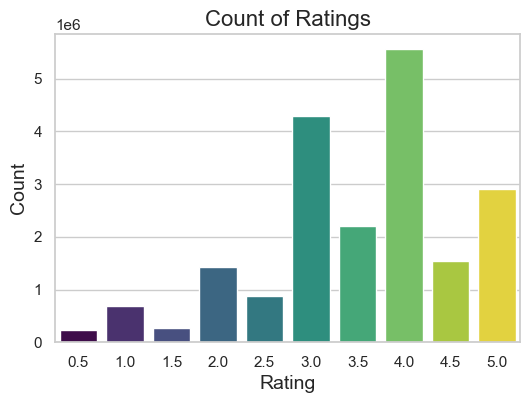

In [46]:
sns.set_theme(style='whitegrid')
rating_counts = rating_df['rating'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=rating_counts.index, y=rating_counts.values, hue=rating_counts.index,palette='viridis',legend=False)
plt.title('Count of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.show()

The important point to note is that the rating values range from 0.5 to 5.0, with 3.0 and 4.0 being the most common ratings.

Additionally, both the Tag and Rating datasets have a timestamp column. It is also a good practice to visualize when the tags and ratings were submitted.

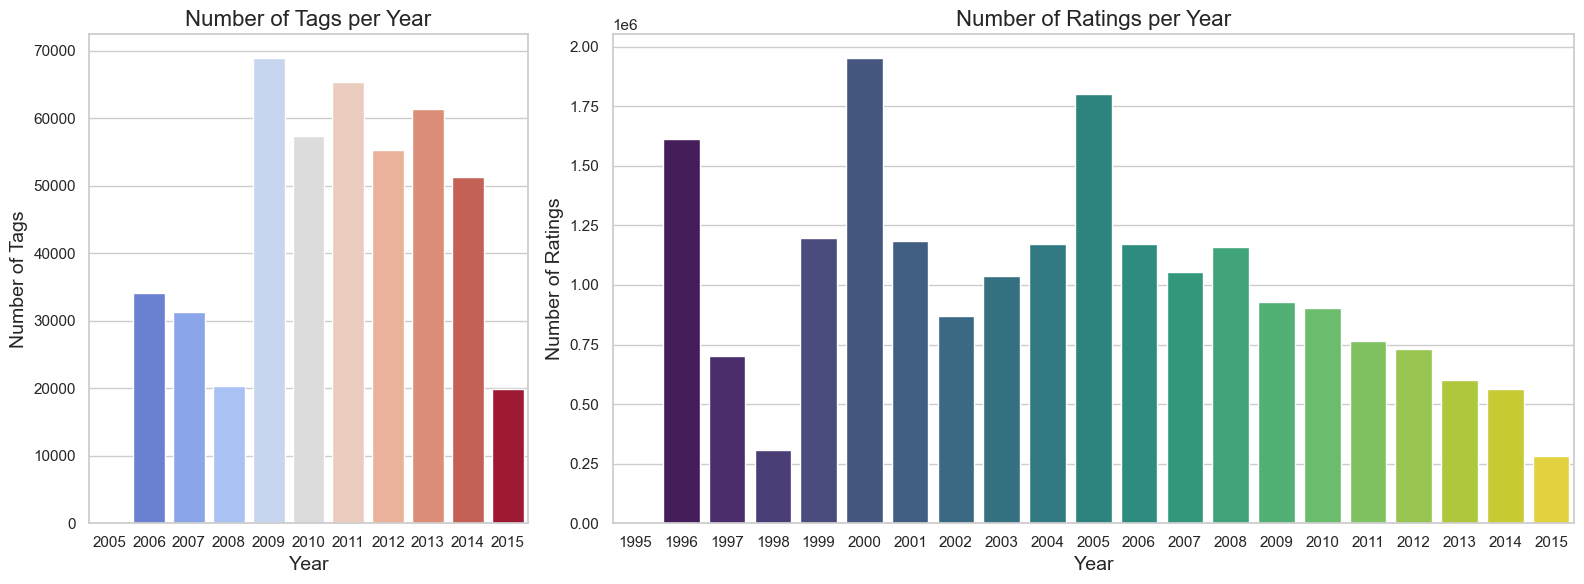

In [47]:
tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'])
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'], errors='coerce')

#Count the number of records for each year
tag_year_counts = tag_df['timestamp'].dt.year.value_counts().sort_index()
rating_year_counts = rating_df['timestamp'].dt.year.value_counts().sort_index()

fig = plt.figure(figsize=(16, 6))


ax1 = fig.add_subplot(1, 3, 1)#Occupies 1/3 of the width
sns.barplot(
    x=tag_year_counts.index,
    y=tag_year_counts.values,
    hue=tag_year_counts.index,
    legend=False,
    palette='coolwarm',
    ax=ax1
)
ax1.set_title('Number of Tags per Year', fontsize=16)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Number of Tags', fontsize=14)

ax2 = fig.add_subplot(1, 3, (2, 3))#Occupies 2/3 of the width
sns.barplot(
    x=rating_year_counts.index.astype(int), 
    
    y=rating_year_counts.values,
    hue=rating_year_counts.index.astype(int),
    legend=False,
    palette='viridis',
    ax=ax2
)
ax2.set_title('Number of Ratings per Year', fontsize=16)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel('Number of Ratings', fontsize=14)


plt.tight_layout()
plt.show()


As shown in the previous two plots:
- The tag submission timestamps range from 2005 to 2015.
- In contrast, ratings were submitted between 1995 and 2015.

We then merge the Movie, Rating, and Link datasets into a single unified dataset. Similarly, we combine the Genome Score and Genome Tag datasets, as they are related by specific keys. This "join" operation consolidates multiple datasets without introducing any additional records. Herein, the final datasets that we will use in this homework are <strong>user_rating</strong>, <strong>tag_relevance</strong>, and <strong>tag</strong>.

In [51]:
user_rating_df = pd.merge(movie_df, rating_df, on='movieId', how='inner')
user_rating_df = pd.merge(user_rating_df, link_df, on='movieId', how='inner') 
tag_relevance_df = pd.merge(genome_scores_df, genome_tags_df, on='tagId', how='left') 

display(user_rating_df)
display(tag_relevance_df)
display(tag_df)

,movieId,title,genres,userId,rating,timestamp,imdbId,tmdbId
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3,4.0,1999-12-11 13:36:47,114709,862.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",6,5.0,1997-03-13 17:50:52,114709,862.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",8,4.0,1996-06-05 13:37:51,114709,862.0
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",10,4.0,1999-11-25 02:44:47,114709,862.0
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",11,4.5,2009-01-02 01:13:41,114709,862.0
...,...,...,...,...,...,...,...,...
20000258,131254,Kein Bund für's Leben (2007),[Comedy],79570,4.0,2015-03-30 19:32:59,466713,4436.0
20000259,131256,"Feuer, Eis & Dosenbier (2002)",[Comedy],79570,4.0,2015-03-30 19:48:08,277703,9274.0
20000260,131258,The Pirates (2014),[Adventure],28906,2.5,2015-03-30 19:56:32,3485166,285213.0
20000261,131260,Rentun Ruusu (2001),[],65409,3.0,2015-03-30 19:57:46,249110,32099.0


,movieId,tagId,relevance,tag
0,1,1,0.02500,007
1,1,2,0.02500,007 (series)
2,1,3,0.05775,18th century
3,1,4,0.09675,1920s
4,1,5,0.14675,1930s
...,...,...,...,...
11709763,131170,1124,0.58775,writing
11709764,131170,1125,0.01075,wuxia
11709765,131170,1126,0.01575,wwii
11709766,131170,1127,0.11450,zombie


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18
...,...,...,...,...
465559,138446,55999,dragged,2013-01-23 23:29:32
465560,138446,55999,Jason Bateman,2013-01-23 23:29:38
465561,138446,55999,quirky,2013-01-23 23:29:38
465562,138446,55999,sad,2013-01-23 23:29:32
